In [1]:
#import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import keras
keras.__version__

'2.14.0'

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu.name, 'memory growth: ',tf.config.experimental.get_memory_growth(gpu))

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [4]:
df = pd.read_csv(csv_path)

Spójrzmy na dane.

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## Zadania do wykonania. Prognozowanie sekwencji.
W prognozowaniu sekwencji, mając punkty pomiarowe z przeszłości, model musi nauczyć się przewidzieć __zakres__ przyszłych wartości. 

Model powinien przewidzieć temperaturę dla kolejnych kilku/kilkunastu pomiarów. Pozostawiam do wyboru ilość pomiarów na dobę (STEP) oraz ilość cech modelu braną do trenowania.
1. Przygotuj odpowiednio dane - w tym celu napisz odpowiedni generator. Przetestuj generator generując odpowiednie rysunki.
2. Zbuduj i wytrenuj rekurencyjną sieć neuronową. W tym przypadku należy ustawić parametr wartswy LSTM: `return_sequences=True`.
3. Wyplotuj krzywe uczenia.
4. Wyplotuj odpowiednie rysunki (patrz funkcja `show_plot`).
5. Oblicz R$^2$
6. Oblicz średni błąd bezwględny dla zestwu testowego i pojedynczych próbek (pamiętaj o dokonanej wcześniej normalizacji).

#### Poniżej generator z książki F. Cholleta.
Obecny generator danych zwraca krotki (samples, targets), w których obiekt samples jest wsadem danych wejściowych, a obiekt targets jest tablicą docelowych temperatur. Generator przyjmuje następujące argumenty:

* `data` — oryginalna tablica danych zmiennoprzecinkowych
* `lookback` — liczba kroków czasu, do których powinny sięgać dane wejściowe;
* `delay` — liczba kroków czasu określających przyszłą temperaturę;
* `min_index` i `max_index` — indeksy tablicy `data` określające kroki, których próbki należy odczytać. Rozwiązanie to przydaje się w celu utworzenia zbioru walidacyjnego i zbioru testowego;
* `shuffle` — określa to czy próbki mają być losowane, czy pobierane w kolejności chronologicznej;
* `batch_size` — liczba próbek wchodzących w skład wsadu;
* `step` — przedział czasu określający częstotliwość próbkowania danych. Parametrowi temu przypisujemy wartość 6, aby dysponować próbką danych odczytanych co godzinę.

In [6]:
'''
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
'''

'\ndef generator(data, lookback, delay, min_index, max_index,\n              shuffle=False, batch_size=128, step=6):\n    if max_index is None:\n        max_index = len(data) - delay - 1\n    i = min_index + lookback\n    while 1:\n        if shuffle:\n            rows = np.random.randint(\n                min_index + lookback, max_index, size=batch_size)\n        else:\n            if i + batch_size >= max_index:\n                i = min_index + lookback\n            rows = np.arange(i, min(i + batch_size, max_index))\n            i += len(rows)\n\n        samples = np.zeros((len(rows),\n                           lookback // step,\n                           data.shape[-1]))\n        targets = np.zeros((len(rows),))\n        for j, row in enumerate(rows):\n            indices = range(rows[j] - lookback, rows[j], step)\n            samples[j] = data[indices]\n            targets[j] = data[rows[j] + delay][1]\n        yield samples, targets\n'

In [6]:
def generator(data, lookback, delay, number_of_features, min_index, max_index,
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),lookback // step, number_of_features))
        targets = np.zeros((len(rows), delay//step, ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            indices_t = range(rows[j], rows[j] + delay, step)
            samples[j] = data[indices,:number_of_features]
            #samples[j] = data[indices]
            targets[j] = data[indices_t,1]
        yield samples, targets

In [7]:
TRAIN_SPLIT = 200000
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
data = df.drop(['Date Time'], axis=1)
dataset = data.values

In [9]:
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [10]:
lookback = 720
step = 6
delay = 72
batch_size = 256
number_of_features = 3

train_gen = generator(dataset,
                      lookback=lookback,
                      delay=delay,
                      number_of_features=number_of_features,
                      min_index=0,
                      max_index=TRAIN_SPLIT,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(dataset,
                    lookback=lookback,
                    delay=delay,
                    number_of_features=number_of_features,
                    min_index=TRAIN_SPLIT + 1,
                    max_index=TRAIN_SPLIT + 100000,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(dataset,
                     lookback=lookback,
                     delay=delay,
                     number_of_features=number_of_features,
                     min_index=TRAIN_SPLIT + 100001,
                     max_index=None,
                     shuffle=False,
                     step=step,
                     batch_size=batch_size)

# Liczba kroków pobierania danych z obiektu val_gen 
# zapewniających przetworzenie całego walidacyjnego zbioru danych.
val_steps = (TRAIN_SPLIT + 100000 - TRAIN_SPLIT + 1 - lookback) // batch_size

# Liczba kroków pobierania danych z obiektu test_gen, 
# przy której przetworzony zostanie cały testowy zbiór danych.
test_steps = (len(dataset) - TRAIN_SPLIT + 100001 - lookback) // batch_size

train_steps = (TRAIN_SPLIT - lookback) // batch_size

Test generatora:

In [11]:
samples, targets = next(train_gen)
print(samples.shape, targets.shape)

(256, 120, 3) (256, 12)


In [12]:
def show_plot(plot_data, delta, prediction, title):

    
    labels = ['Historia pomiarów', 'Prawdziwa wartość', 'Prognozowana wartość']
    marker = ['.-', 'bo', 'ro']
    length = len(plot_data)
    time_steps = list(range(-length, 0))
    delta_steps = list(range(0, len(delta)))
    pred_steps = list(range(0, len(prediction)))
    future = len(prediction)
    
    plt.title(title)
    
    plt.plot(time_steps, plot_data, marker[0], markersize=10, label=labels[0])
    plt.plot(delta_steps, delta, marker[1], markersize=5, label=labels[1])
    if len(prediction) > 1:
        plt.plot(pred_steps, prediction, marker[2], markersize=5, label=labels[2])
    
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Czas')
    return plt

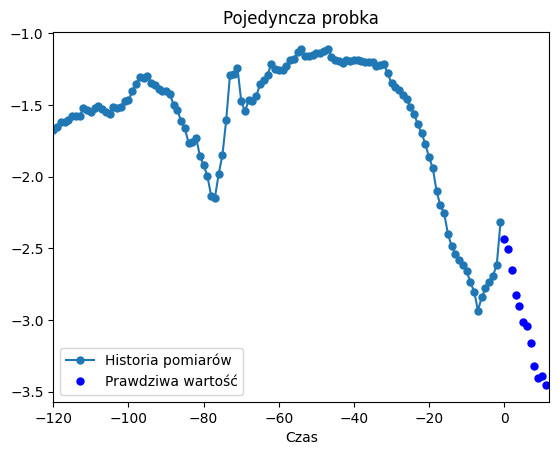

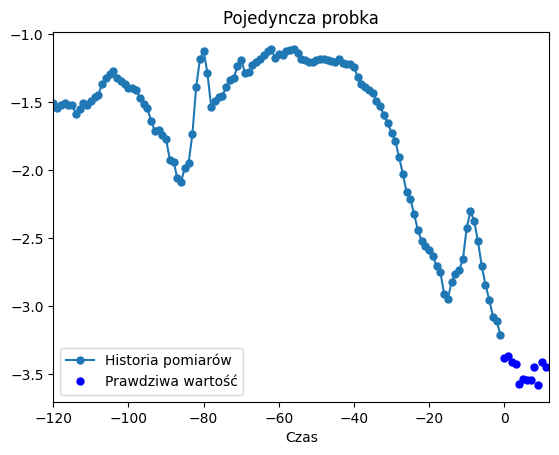

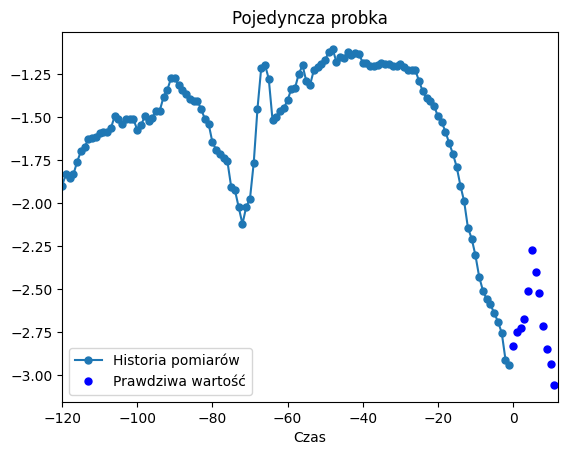

In [13]:
for i in range(3):
    index = np.random.randint(0, batch_size)
    plot = show_plot(samples[index][:,1], targets[index], [0], 'Pojedyncza probka')
    plot.show()

2. Zbuduj i wytrenuj rekurencyjną sieć neuronową. W tym przypadku należy ustawić parametr wartswy LSTM: `return_sequences=True`.
3. Wyplotuj krzywe uczenia.
4. Wyplotuj odpowiednie rysunki (patrz funkcja `show_plot`).
5. Oblicz R$^2$
6. Oblicz średni błąd bezwględny dla zestwu testowego i pojedynczych próbek (pamiętaj o dokonanej wcześniej normalizacji).

In [42]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(None,samples.shape[-1])))

model.add(LSTM(50))

model.add(Dense(delay//step))

In [43]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [44]:
history = model.fit(train_gen, epochs=2, steps_per_epoch=train_steps,validation_data=val_gen, validation_steps=val_steps)

Epoch 1/2
778/778 [==============================] - 255s 327ms/step - loss: 0.2460 - val_loss: 0.2509
Epoch 2/2
778/778 [==============================] - 255s 328ms/step - loss: 0.1164 - val_loss: 0.0996


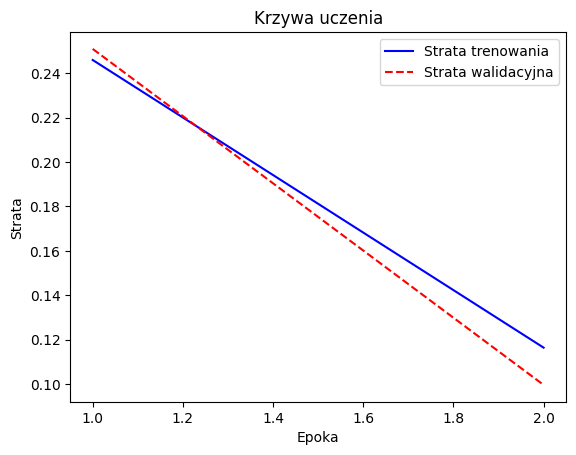

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs,loss, 'b-', label="Strata trenowania")

plt.plot(epochs, val_loss, 'r--', label="Strata walidacyjna")
plt.title("Krzywa uczenia")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()

plt.show()

In [47]:
predictions = model.predict(test_gen, steps=test_steps)


predictions = predictions * data_std[1] + data_mean[1]

print(predictions)




1249/1249 [==============================] - 100s 80ms/step
[[ 0.3347826   0.2737112   0.42182446 ... -0.2399149   0.03411865
   0.02850723]
 [ 0.31387806  0.25004387  0.39476967 ... -0.22623158  0.05806351
   0.05970669]
 [ 0.31163025  0.24150848  0.3831625  ... -0.20439243  0.08877945
   0.09798717]
 ...
 [11.534211   13.303573   14.720046   ... 15.158314   14.215057
  12.677933  ]
 [12.163755   13.876731   15.222952   ... 15.1551     14.1725
  12.688484  ]
 [12.701032   14.342348   15.608962   ... 15.019127   13.994884
  12.554583  ]]


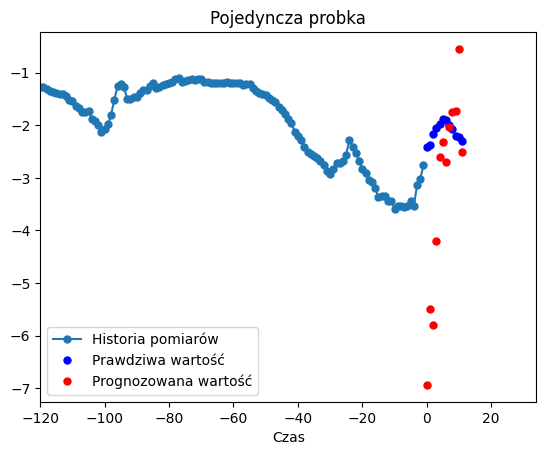

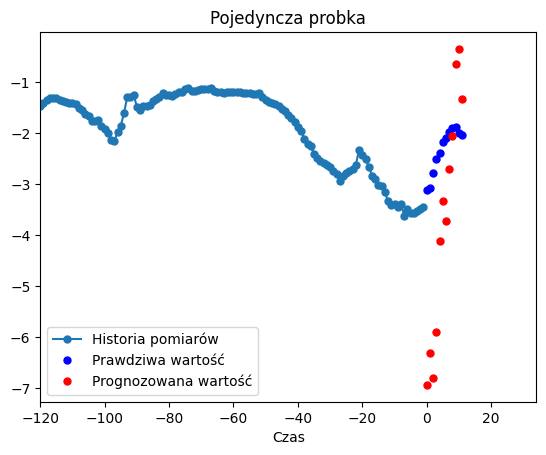

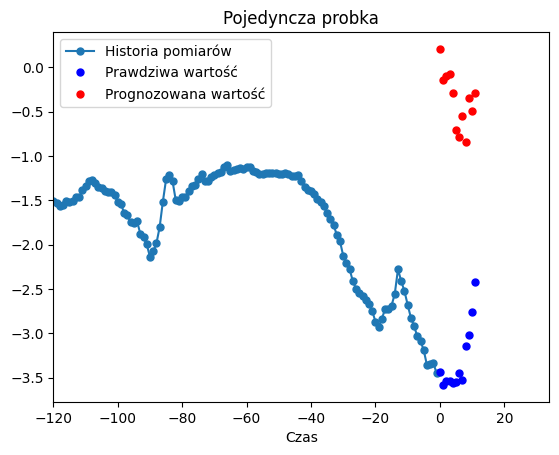

In [56]:
for i in range(3):
    index = np.random.randint(0, batch_size)
    plot = show_plot(samples[index][:,1], targets[index], predictions[index], 'Pojedyncza probka')
    plot.show()